# Machine Learning

In [1]:
# global imports
import pandas as pd
import matplotlib.pyplot as plt
# pyspark
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
from pyspark.sql import Window
# machine learning models
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import NaiveBayes, LinearSVC, LogisticRegression
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# cross validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

spark = SparkSession.builder.getOrCreate()

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
train = spark.createDataFrame(dfs[0])
train.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[0,2,16,22,4...|      0.0|
|(349,[5,7,8,158,1...|      1.0|
+--------------------+---------+
only showing top 2 rows



In [4]:
test = spark.createDataFrame(dfs[1])
test.show(2)

+--------------------+---------+
|           count_vec|label_idx|
+--------------------+---------+
|(349,[2,58,118,12...|      0.0|
|(349,[0,4,134,186...|      1.0|
+--------------------+---------+
only showing top 2 rows



# Build Classification Models

In [5]:
# classification evaluator
class_eval =  BinaryClassificationEvaluator().setLabelCol('label_idx').setMetricName('areaUnderPR')

## 1) Random Forest

***Cross Validation to Determine`numTrees`***

In [6]:
# create random forest model
rf_cv = RandomForestClassifier(featuresCol='count_vec',labelCol='label_idx',featureSubsetStrategy='sqrt')\
                              .setSeed(135)
# parameter grid
pars21 = ParamGridBuilder().addGrid(rf_cv.numTrees,[10,100,500,1000]).build()

# classification evaluator (done at beginning)

# create cross validator
cv_rf = CrossValidator().setEstimator(rf_cv)\
                        .setEvaluator(class_eval)\
                        .setEstimatorParamMaps(pars21)\
                        .setNumFolds(5)\
                        .setSeed(135)

In [7]:
# CODE FOR RUNNING THE CROSS VALIDATION
# run cross validation
cv_rf_model = cv_rf.fit(train)
# get best model
best_rf = cv_rf_model.bestModel
# output best parameter
best_rf._java_obj.getNumTrees()

1000

***Test the Model***

In [8]:
# create the final model
rf = RandomForestClassifier(featuresCol='count_vec',labelCol='label_idx',featureSubsetStrategy='sqrt',numTrees=1000)\
                            .setSeed(135)
# train the model
rf_model = rf.fit(train)
# obtain predictions for test
test_rf = rf_model.transform(test)

In [9]:
# create confusion matrix
confusion_matrix_rf = test_rf.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_rf.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,1370,223
1,0.0,2755,24


Out of 4,372 observations, it misclassified 1,394. This means it had 68.12% accuracy.

In [10]:
# obtain test area under PR
test_PR_rf = class_eval.evaluate(test_rf)
print("Area under PR on test data for Random Forest model: ", test_PR_rf)

Area under PR on test data for Random Forest model:  0.7079424515842226


In [11]:
# add predictions to ml_results
ml_results = test_rf.select('count_vec','label_idx','prediction')
ml_results = ml_results.withColumnRenamed('prediction','rf_pred')
ml_results = ml_results.withColumn('id', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))

## 2) Gradient Boosted Tree

***Cross Validation to Determine `stepSize` and `maxIter`***

In [12]:
# create gbt model
gbt_cv = GBTClassifier(featuresCol='count_vec', labelCol='label_idx').setSeed(135)
# parameter grid
pars23 = ParamGridBuilder().addGrid(gbt_cv.stepSize,[0.1,0.5,0.9])\
                           .addGrid(gbt_cv.maxIter,[50,100,200])\
                           .build()
# create cross validator
cv_gbt = CrossValidator().setEstimator(gbt_cv)\
                         .setEvaluator(class_eval)\
                         .setEstimatorParamMaps(pars23)\
                         .setNumFolds(5)\
                         .setSeed(135)

In [13]:
# CROSS VALIDATION

# run cross validation
cv_gbt_model = cv_gbt.fit(train)
# get best model
best_gbt = cv_gbt_model.bestModel
# output best parameters
print('Best Step Size: ',best_gbt._java_obj.getStepSize())
print('Best Number of Trees: ',best_gbt._java_obj.getMaxIter())

Best Step Size:  0.1
Best Number of Trees:  200


***Test the Model***

In [14]:
# create the final model
gbt = GBTClassifier(featuresCol='count_vec', labelCol='label_idx', stepSize=0.1,maxIter=200).setSeed(135)
# train the model
gbt_model = gbt.fit(train)
# obtain predictions for test
test_gbt = gbt_model.transform(test)

In [15]:
# create confusion matrix
confusion_matrix_gbt = test_gbt.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_gbt.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,591,1002
1,0.0,2423,356


Out of 4,372 observations it misclassified 947. This means it had 78.34% accuracy.

In [16]:
# obtain test area under PR
test_PR_gbt = class_eval.evaluate(test_gbt)
print("Area under PR on test data for GBT model: ", test_PR_gbt)

Area under PR on test data for GBT model:  0.7753903094997101


In [17]:
# add predictions to ml_results
add_col = test_gbt.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','gbt_pred')

## 3) Naive Bayes

***Cross Validation to Determine `smoothing`***

In [18]:
# train a Naive Bayes model
nb = NaiveBayes(labelCol="label_idx", featuresCol="count_vec")

# parameter grid
parsnb = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).build()

# create cross validator
cv_nb = CrossValidator().setEstimator(nb)\
                         .setEvaluator(class_eval)\
                         .setEstimatorParamMaps(parsnb)\
                         .setNumFolds(5)\
                         .setSeed(135)

In [19]:
# run cross validation
cv_nb_model = cv_nb.fit(train)
# get best model
best_nb = cv_nb_model.bestModel

***Test the Model***

In [20]:
test_nb = best_nb.transform(test)

In [21]:
# create confusion matrix
confusion_matrix_nb = test_nb.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_nb.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,522,1071
1,0.0,2328,451


Out of 4,372 observations it misclassified 973. This means it had 77.74% accuracy which is very similar to GBT.

In [22]:
# obtain test area under PR
test_PR_nb = class_eval.evaluate(test_nb)
print("Area under PR on test data for Naive Bayes model: ", test_PR_nb)

Area under PR on test data for Naive Bayes model:  0.5847643457419713


In [23]:
# add predictions to ml_results
add_col = test_nb.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','nb_pred')

## 4) Logistic Regression

### 4a) OLS

***Test the Model***

In [24]:
# create the final model
ols = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1, regParam=0.0)
# train the model
ols_model = ols.fit(train)
# obtain predictions for test
test_ols = ols_model.transform(test)

In [25]:
# create confusion matrix
confusion_matrix_ols = test_ols.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_ols.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,465,1128
1,0.0,2319,460


Out of 4,372 observations it misclassified 925. This means it had 78.84% accuracy.

In [26]:
# test error
test_error_ols = class_eval.evaluate(test_ols)
print("area under PR on test data for OLS: ", test_error_ols)

area under PR on test data for OLS:  0.7890453364897201


Visualization of area under PR:

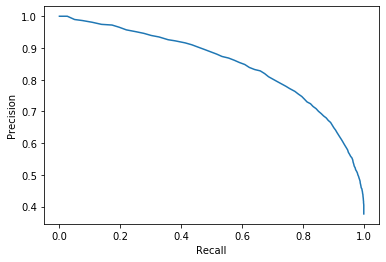

In [27]:
logistic_summary = ols_model.summary

# visualize area under the precision-recall curve
pr = logistic_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [28]:
# add predictions to ml_results
add_col = test_ols.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','ols_pred')

### 4b) Lasso Regression

***Cross Validation to Determine `regParam`***

In [29]:
# create lasso model
lasso_cv = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1)
# parameter grid
pars111 = ParamGridBuilder().addGrid(lasso_cv.regParam,[0.1,1,5,10]).build()
# regression evaluator (CHANGE EVALUATOR?)
#reg_eval = RegressionEvaluator().setMetricName('rmse').setLabelCol('label_idx')
class_eval =  BinaryClassificationEvaluator().setLabelCol('label_idx').setMetricName('areaUnderPR')
# create cross validator
cv_lasso_1 = CrossValidator().setEstimator(lasso_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars111)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [30]:
# run cross validation
cv_lasso_model_1 = cv_lasso_1.fit(train)
# get best model
best_lasso_1 = cv_lasso_model_1.bestModel
# output best parameter
best_lasso_1._java_obj.getRegParam()

0.1

Ran cross validation a second time:

In [31]:
# parameter grid
pars112 = ParamGridBuilder().addGrid(lasso_cv.regParam,[0.0001,0.001,0.1,0.5]).build()
# create cross validator
cv_lasso_2 = CrossValidator().setEstimator(lasso_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars112)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [32]:
# run cross validation asecond time
cv_lasso_model_2 = cv_lasso_2.fit(train)
# get best model
best_lasso_2 = cv_lasso_model_2.bestModel
# output best parameter
best_lasso_2._java_obj.getRegParam()

0.001

The final lasso regression model will use `regParam=0.001`.

***Test the Model***

In [33]:
# create the final model
lasso = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=1, regParam=0.001)
# train the model
lasso_model = lasso.fit(train)
# obtain predictions for test
test_lasso = lasso_model.transform(test)

In [34]:
# create confusion matrix
confusion_matrix_lasso = test_lasso.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_lasso.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,469,1124
1,0.0,2327,452


Out of 4,372 observations it misclassified 921. This means it had 78.93% accuracy.

In [35]:
# test error
test_error_lasso = class_eval.evaluate(test_lasso)
print("area under PR on test data for lasso: ", test_error_lasso)

area under PR on test data for lasso:  0.7920453750738372


Visualization of area under PR:

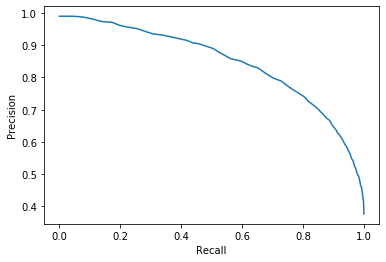

In [36]:
logistic_summary_lasso = lasso_model.summary

# Precision-Recall Curve
pr2 = logistic_summary_lasso.pr.toPandas()
plt.plot(pr2['recall'],pr2['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [37]:
# add predictions to ml_results
add_col = test_lasso.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','lasso_pred')

### 4c) Ridge Regression

***Cross Validation to Determine `regParam`***

In [38]:
# create ridge model
ridge_cv = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=0)
# parameter grid
pars121 = ParamGridBuilder().addGrid(ridge_cv.regParam,[0.1,1,5,10]).build()
# create cross validator
cv_ridge_1 = CrossValidator().setEstimator(ridge_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars121)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [39]:
# run cross validation
cv_ridge_model_1 = cv_ridge_1.fit(train)
# get best model
best_ridge_1 = cv_ridge_model_1.bestModel
# output best parameter
best_ridge_1._java_obj.getRegParam()

0.1

Run cross validation a second time:

In [40]:
# parameter grid
pars122 = ParamGridBuilder().addGrid(ridge_cv.regParam,[0.001,0.01,0.1,0.5]).build()
# create cross validator
cv_ridge_2 = CrossValidator().setEstimator(ridge_cv)\
                             .setEvaluator(class_eval)\
                             .setEstimatorParamMaps(pars122)\
                             .setNumFolds(5)\
                             .setSeed(135)

In [41]:
# run cross validation a second time
cv_ridge_model_2 = cv_ridge_2.fit(train)
# get best model
best_ridge_2 = cv_ridge_model_2.bestModel
# output best parameter
best_ridge_2._java_obj.getRegParam()

0.1

The final ridge regression model will use `regParam=0.1`.

***Test the Model***

In [42]:
# create the final model
ridge = LogisticRegression(featuresCol='count_vec', labelCol='label_idx', elasticNetParam=0, regParam=0.1)
# train the model
ridge_model = ridge.fit(train)
# obtain predictions for test
test_ridge = ridge_model.transform(test)

In [43]:
# create confusion matrix
confusion_matrix_ridge = test_ridge.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_ridge.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,590,1003
1,0.0,2479,300


Out of 4,372 observations it misclassified 890. This means it had 79.64% accuracy.

In [44]:
# test error
test_error_ridge = class_eval.evaluate(test_ridge)
print("area under PR on test data for ridge: ", test_error_ridge)

area under PR on test data for ridge:  0.7936207689440488


Visualization of area under PR:

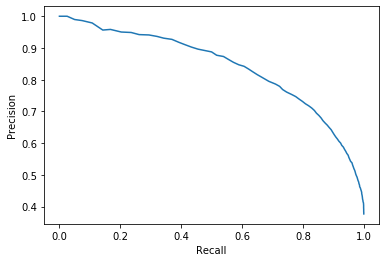

In [45]:
logistic_summary_ridge = ridge_model.summary

# Precision-Recall Curve
pr3 = logistic_summary_ridge.pr.toPandas()
plt.plot(pr3['recall'],pr3['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [46]:
# add predictions to ml_results
add_col = test_ridge.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','ridge_pred')

## 5) Linear Support Vector Machine

***Cross Validation to Determine `maxIter` and `regParam`***

In [47]:
# create linear support vector machine model
lsvc = LinearSVC(labelCol="label_idx", featuresCol="count_vec")

# parameter builder
parssvm = ParamGridBuilder().addGrid(lsvc.maxIter,[50, 100, 200])\
                            .addGrid(lsvc.regParam,[0.01, 0.1, 1])\
                            .build()

# create cross validator
cv_lsvc = CrossValidator().setEstimator(lsvc)\
                         .setEvaluator(class_eval)\
                         .setEstimatorParamMaps(parssvm)\
                         .setNumFolds(5)\
                         .setSeed(135)

In [48]:
# run cross validation
cv_lsvc_model = cv_lsvc.fit(train)
# get best model
best_lsvc = cv_lsvc_model.bestModel

***Test the Model***

In [49]:
# fit best model on test
lsvc_test = best_lsvc.transform(test)

# create confusion matrix
confusion_matrix_lsvc = lsvc_test.select('label_idx','prediction')
# ‘label’ is row and ‘prediction’ is column
confusion_matrix_lsvc.stat.crosstab('label_idx','prediction').toPandas()

,label_idx_prediction,0.0,1.0
0,1.0,495,1098
1,0.0,2387,392


Out of 4,372 observations it successfully classified 3485. The accuracy rate is 79.71%.

In [50]:
# add predictions to ml_results
add_col = lsvc_test.select('prediction')
add_col = add_col.withColumn('id2', W.row_number().over(Window.orderBy(W.monotonically_increasing_id())))
ml_results = ml_results.join(add_col,(ml_results.id==add_col.id2))
ml_results = ml_results.drop('id2')
ml_results = ml_results.withColumnRenamed('prediction','lsvc_pred')

# Save Data Frames

In [51]:
# store data frames for additional programs
ml_dfs = [lsvc_test.toPandas(), ml_results.toPandas()]
%store ml_dfs

Stored 'ml_dfs' (list)
